In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

In [3]:
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(df_small_noise_url)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url)

In [4]:
print(df_small_noise.head())

print(df_daily_jumpsup.head())

             timestamp      value
0  2014-04-01 00:00:00  18.324919
1  2014-04-01 00:05:00  21.970327
2  2014-04-01 00:10:00  18.624806
3  2014-04-01 00:15:00  21.953684
4  2014-04-01 00:20:00  21.909120
             timestamp      value
0  2014-04-01 00:00:00  19.761252
1  2014-04-01 00:05:00  20.500833
2  2014-04-01 00:10:00  19.961641
3  2014-04-01 00:15:00  21.490266
4  2014-04-01 00:20:00  20.187739


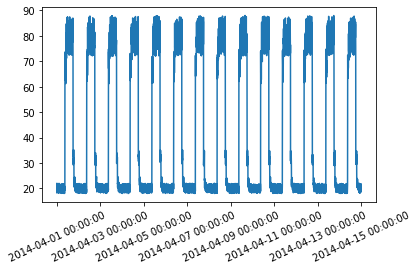

In [19]:
def plot_dates_values(data):
    dates = data["timestamp"].to_list()
    values = data["value"].to_list()
    
    #datetime.strptime() 클래스 메서드는 날짜와 시간을 나타내는 문자열과 해당 포맷 문자열로 datetime 객체를 만듭니다.
    #https://docs.python.org/ko/3/library/datetime.html#strftime-strptime-behavior
    dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]

    #plt.subplots_adjust()메소드를 사용하여 서브 플롯 간 간격을 변경할 수 있습니다
    #https://www.delftstack.com/ko/howto/matplotlib/how-to-improve-subplot-size-or-spacing-with-many-subplots-in-matplotlib/#plt.subplots_adjust%25EB%25A9%2594%25EC%2586%258C%25EB%2593%259C
    plt.subplots_adjust(bottom=0.2)

    #xticks(), yticks() 함수는 각각 x축, y축에 눈금을 표시합니다.
    #Xticks 레이블 텍스트를 회전하는 plt.xticks(rotation =)
    #https://www.delftstack.com/ko/howto/matplotlib/how-to-rotate-x-axis-tick-label-text-in-matplotlib/
    plt.xticks(rotation=25)
    
    #현재의 axes 객체를 구해준다??
    ax = plt.gca()

    #https://jaeworld.github.io/visualization/DateFormatter/
    xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
    ax.xaxis.set_major_formatter(xfmt)
    plt.plot(dates, values)
    plt.show()
    
plot_dates_values(df_small_noise)

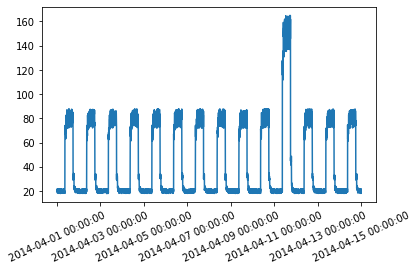

In [7]:
plot_dates_values(df_daily_jumpsup)

In [8]:
# df의 value 컬럼 값들을 list로 뽑아내는 듯
def get_value_from_df(df):
    return df.value.to_list()

# 평균 0, 표준편차 1로 표준화(정규화) 해주는 듯
def normalize(values):
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std

# value 컬럼 값을 df_small_noise에서 뽑아서 training_value에 넣어줌
training_value = get_value_from_df(df_small_noise)

#normalize 함수를 이용해서 표준화 된 values, mean, std를 구한다
training_value, training_mean, training_std = normalize(training_value)

#len(traning_value)가 4032가 나오는 이유는 데이터가 5분 단위로 찍혀있으니 하루에 24시간 * 60분 / 5분 = 288, 14일 동안 측정되었으니 288*14 = 4032
len(training_value)

4032

In [9]:
TIME_STEPS = 288

# 이 함수의 의미?
# 그 내가 발표한 mad-gan에서 window size를 step사이즈로 겹쳐서 input data를 만드는 거였는데 이것도 그건가?
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    # for i in range(4032 - 288)
    for i in range(len(values) - time_steps):
      #output.append(values[0:288]),1:289,2:290 .... 이런식으로 진행됨(겹쳐지는 건가?)
      output.append(values[i : (i + time_steps)])
    
    # 2D 시퀀스를 3D 시퀀스로 변경하고, 이 시퀀스를 컨볼루션 레이어로 공급합니다.
    # output의 3번째 축에 새로운 차원을 만들겠다.
    return np.expand_dims(output, axis=2)
    

x_train = create_sequences(training_value)
print("Training input shape: ", x_train.shape)

# shape이 (3744, 288, 1) 이렇게 나왔는데 for 문이 3744번 반복되고, 그 한번에 288개, 차원 늘려줘서 마지막은 1? 이렇게 보면 되나

Training input shape:  (3744, 288, 1)


In [23]:
x_train
# 결과를 보면 두번째 줄에 잇는 -0.7290 뭐시기가 그 다음에 첫번째로 나옴

array([[[-0.85893509],
        [-0.72908344],
        [-0.84825292],
        ...,
        [-0.8646447 ],
        [-0.81260907],
        [-0.79681037]],

       [[-0.72908344],
        [-0.84825292],
        [-0.72967628],
        ...,
        [-0.81260907],
        [-0.79681037],
        [-0.78777715]],

       [[-0.84825292],
        [-0.72967628],
        [-0.73126368],
        ...,
        [-0.79681037],
        [-0.78777715],
        [-0.73715429]],

       ...,

       [[-0.82415016],
        [-0.82275683],
        [-0.86671724],
        ...,
        [-0.80188874],
        [-0.7917448 ],
        [-0.78035169]],

       [[-0.82275683],
        [-0.86671724],
        [-0.82191556],
        ...,
        [-0.7917448 ],
        [-0.78035169],
        [-0.83374388]],

       [[-0.86671724],
        [-0.82191556],
        [-0.75605211],
        ...,
        [-0.78035169],
        [-0.83374388],
        [-0.73519331]]])

In [26]:
# 모델 만드는 line임
# convolutional reconstruction autoencoder 모델을 만든다고 함
# input의 shape은 (batch_size, sequence_length, num_feature)이고 output도 같은 shape
# 여기서 sequence_length는 288, num_feature은 1

#아까 x_train의 shape이 (3744, 288, 1)이므로 이렇게 갖다 씀
n_steps = x_train.shape[1]
n_features = x_train.shape[2]

# For easy reset of notebook state.
#clear_session() 호출 하면 전역 상태가 해제됩니다. 이는 특히 메모리가 제한된 경우 이전 모델 및 레이어의 혼란을 방지하는 데 도움이됩니다.
#https://runebook.dev/ko/docs/tensorflow/keras/backend/clear_session
keras.backend.clear_session()

model = keras.Sequential(
    [
        layers.Input(shape=(n_steps, n_features)),
        # https://keras.io/ko/layers/convolutional/
        # https://runebook.dev/ko/docs/tensorflow/keras/layers/conv1d
        # https://tykimos.github.io/2017/01/27/CNN_Layer_Talk/
        # kernel_size = 15 : kernel_size: 정수 혹은 단일 정수의 튜플/리스트. 1D 컨볼루션 윈도우의 길이를 특정합니다.
        # padding='same' : 출력 이미지 사이즈가 입력 이미지 사이즈와 동일합니다.
        # activation="linear" :‘linear' -> 디폴트 값, 입력뉴런과 가중치로 계산된 결과값이 그대로 출력으로 나옵니다.
        layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last',
            dilation_rate=1, activation="linear"),
        
        #https://tykimos.github.io/2017/04/09/RNN_Getting_Started/ 
        #return_sequences=False
        layers.LSTM(
            units=25, activation="tanh", name="lstm_1", return_sequences=False
        ),

        # Input을 n_steps만큼 반복한다 - https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector (입력모양과 출력모양 주의)
        layers.RepeatVector(n_steps),
        layers.LSTM(
            units=25, activation="tanh", name="lstm_2", return_sequences=True
        ),
        layers.Conv1D(filters=32, kernel_size=15, padding='same', data_format='channels_last',
            dilation_rate=1, activation="linear"),
        
        # 이 함수는 잘 이해가 되지 않음. 각각의 타임 스탭에 독립적으로 동일한 layer을 적용한다는 거 같은데
        layers.TimeDistributed(layers.Dense(1, activation='linear'))
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 288, 32)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 25)                5800      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 288, 25)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 288, 25)           5100      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 288, 32)           12032     
_________________________________________________________________
time_distributed (TimeDistri (None, 288, 1)            33        
Total params: 23,477
Trainable params: 23,477
Non-trainable params: 0
____________________________________________________

In [27]:
# Please note that we are using x_train as both the input and the target since this is a reconstruction model.
history = model.fit(
    x_train,
    x_train,
    epochs=200,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=25, mode="min", restore_best_weights=True)
    ],
)
#EarlyStopping에 대한 설명 : https://3months.tistory.com/424

Epoch 1/200
27/27 [==============================] - 17s 490ms/step - loss: 0.9942 - val_loss: 0.9891
Epoch 2/200
27/27 [==============================] - 12s 452ms/step - loss: 0.9412 - val_loss: 0.9409
Epoch 3/200
27/27 [==============================] - 13s 463ms/step - loss: 0.9049 - val_loss: 0.9192
Epoch 4/200
27/27 [==============================] - 12s 457ms/step - loss: 0.8917 - val_loss: 0.9481
Epoch 5/200
27/27 [==============================] - 12s 449ms/step - loss: 0.9060 - val_loss: 0.9087
Epoch 6/200
27/27 [==============================] - 12s 452ms/step - loss: 0.8828 - val_loss: 0.8993
Epoch 7/200
27/27 [==============================] - 12s 445ms/step - loss: 0.8747 - val_loss: 0.8920
Epoch 8/200
27/27 [==============================] - 12s 450ms/step - loss: 0.8634 - val_loss: 0.8929
Epoch 9/200
27/27 [==============================] - 12s 456ms/step - loss: 0.8785 - val_loss: 0.9002
Epoch 10/200
27/27 [==============================] - 12s 454ms/step - loss: 0.853

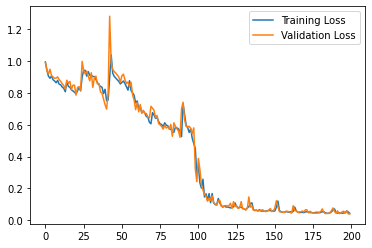

In [28]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [29]:
# 이상치 탐지
# We will detect anomalies by determining how well our model can reconstruct the input data.

#Find MAE loss on training samples.
# MAE :Mean Absolute Error 
#Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the threshold for anomaly detection.
#If the reconstruction loss for a sample is greater than this threshold value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

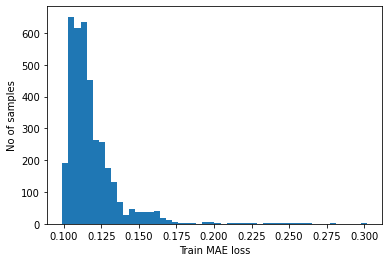

Reconstruction error threshold:  0.30173985396766334


In [30]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
#axis =1 ? 이건 무슨 의미?
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

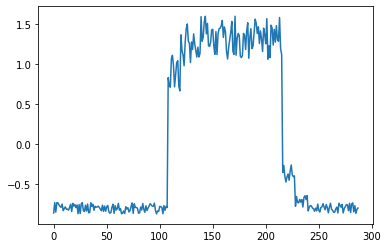

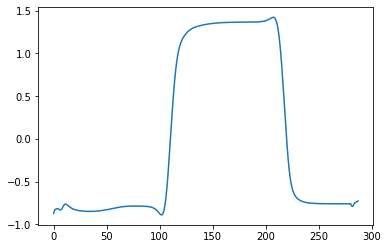

In [31]:
# 우리의 training data set의 day1을 어떻게 model이 잘 reconstruct했는지 확인 (just fun)
# Checking how the first sequence is learnt
# 궁금한 것은 x_train의 shape이 처음에 (3744,288,1) 이었던 거 같은데 model에 의해 reconstruction 되어서 shape이 바뀐건가? 확인해볼 필요가 있음
plt.plot(x_train[0])
plt.show()
plt.plot(x_train_pred[0])
plt.show()

In [36]:
x_train.shape

(3744, 288, 1)

In [37]:
# 궁금한 것은 x_train의 shape이 처음에 (3744,288,1) 이었던 거 같은데 model에 의해 reconstruction 되어서 shape이 바뀐건가? 확인해볼 필요가 있음
# 이거는 내가 잘 못 생각한듯, 하지만 여전히 구조에 대한 의문점은 있음
x_train[3743]

array([[-0.86671724],
       [-0.82191556],
       [-0.75605211],
       [-0.74265963],
       [-0.79667189],
       [-0.80560791],
       [-0.86611692],
       [-0.74523773],
       [-0.86865516],
       [-0.73589862],
       [-0.80080417],
       [-0.82178923],
       [-0.73882401],
       [-0.8670336 ],
       [-0.78766606],
       [-0.79229566],
       [-0.83925959],
       [-0.80939997],
       [-0.77757274],
       [-0.76690548],
       [-0.87040675],
       [-0.73702375],
       [-0.84706691],
       [-0.83722778],
       [-0.83296855],
       [-0.86512018],
       [-0.85297612],
       [-0.72997137],
       [-0.82559605],
       [-0.85408051],
       [-0.85526451],
       [-0.76799849],
       [-0.74874788],
       [-0.8338977 ],
       [-0.86752965],
       [-0.83872248],
       [-0.86245639],
       [-0.85577693],
       [-0.80902657],
       [-0.83774956],
       [-0.79699567],
       [-0.83439048],
       [-0.73649886],
       [-0.7414278 ],
       [-0.78974898],
       [-0

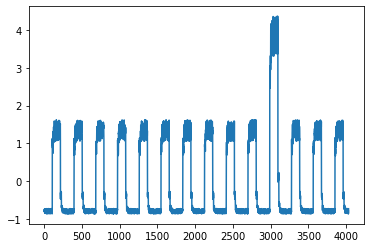

Test input shape:  (3744, 288, 1)


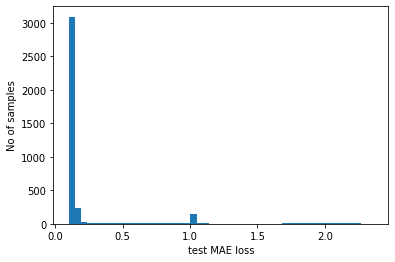

Number of anomaly samples:  371
Indices of anomaly samples:  (array([2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715,
       2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726,
       2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737,
       2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748,
       2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
       2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770,
       2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781,
       2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792,
       2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803,
       2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814,
       2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825,
       2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836,
       2837, 2838, 2839, 2840, 2841, 2842, 2843, 2844, 2845, 2

In [38]:
# 테스트 데이터 준비
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values


test_value = get_value_from_df(df_daily_jumpsup)
test_value = normalize_test(test_value, training_mean, training_std)
plt.plot(test_value.tolist())
plt.show()

# Create sequences from test values.
x_test = create_sequences(test_value)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

#reshape((-1))이 뭘까 밑에 구조 확인해보긴 했음
#https://rfriend.tistory.com/345
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = (test_mae_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [39]:
train_mae_loss

array([[0.10980248],
       [0.10710461],
       [0.10502274],
       ...,
       [0.11105526],
       [0.11080294],
       [0.1102254 ]])

In [42]:
a=train_mae_loss.reshape((-1))

In [41]:
train_mae_loss.shape

(3744, 1)

In [43]:
a.shape

(3744,)

In [44]:
# 이상 데이터 분포를 보면 2705부터 3075이며 그래프를 보면 더 확실하게 알 수 있다.
# 이 방법을 여기서 쓰지 않아도 될 거 같은데, kaggle에서 설명하는 탐지 방법은 5라는 데이터 포인트가 이상데이터를 나타낸다면 [3,4,5],[4,5,6],[5,6,7] 이 3개가 다 이상하다고 
# 나타낼 거기 때문에 이를 바탕으로 5라는 데이터 포인트를 추출해낼 수 있다고 설명하는 듯
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
# for data_idx in rang(287,3745)
for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
    time_series = range(data_idx - TIME_STEPS + 1, data_idx)
    if all([anomalies[j] for j in time_series]):
        anomalous_data_indices.append(data_idx)

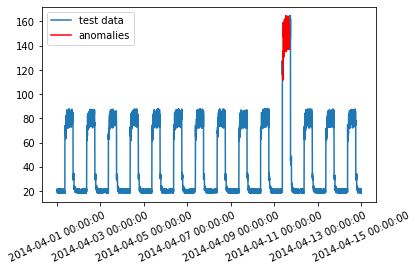

In [45]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices, :]
plt.subplots_adjust(bottom=0.2)
plt.xticks(rotation=25)
ax = plt.gca()
xfmt = md.DateFormatter("%Y-%m-%d %H:%M:%S")
ax.xaxis.set_major_formatter(xfmt)

dates = df_daily_jumpsup["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_daily_jumpsup["value"].to_list()
plt.plot(dates, values, label="test data")

dates = df_subset["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = df_subset["value"].to_list()
plt.plot(dates, values, label="anomalies", color="r")

plt.legend()
plt.show()

In [46]:
len(test_value)

4032

In [47]:
TIME_STEPS

288